In [1]:
# data munging and visualization
import numpy as np
import pandas as pd
import itertools

# class imbalance treatment
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# feature engineering
import featuretools as ft

# predictor -> classification, regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score

# miscellanous
import datetime
import os

# external functions
import utils

# parallelization
from dask import bag
from dask.diagnostics import ProgressBar

In [2]:
pbar = ProgressBar()
pbar.register()

# Unparallelized pipeline (iteration 1)

In [27]:
sample_user_ratio = 1000

In [32]:
# users entity
user_details = pd.read_csv("data/users_1y_6mCustomerValue.csv")
user_details['bux_account_created_dts'] = pd.to_datetime(user_details['bux_account_created_dts'])
user_details['month_year'] = user_details['bux_account_created_dts'].apply(lambda x: x.strftime('%B-%Y'))

cohort_limit_df = utils.calculate_cohort_limit(user_details, sample_user_ratio)

user_details_temp = pd.DataFrame()
for month_year in cohort_limit_df["month_year"]:
    user_details_temp = user_details_temp.append(utils.limit_users(cohort_limit_df, user_details, month_year))

user_details = user_details_temp
distinct_users = user_details["user_id"].unique()

In [33]:
len(distinct_users)

560

In [34]:
# # transactions entity
daily_transactions = transactions = pd.read_csv('data/cube_1y_6mCustomerValue.csv')
daily_transactions['date'] = pd.to_datetime(daily_transactions['date'])
daily_transactions = daily_transactions[daily_transactions.columns[1:]]
daily_transactions.reset_index(inplace=True,drop=True)
daily_transactions.reset_index(inplace=True)
daily_transactions.rename(columns={'index': 'transaction_id'}, inplace=True)
daily_transactions = daily_transactions[daily_transactions['user_id'].isin(distinct_users)]

In [35]:
len(daily_transactions['user_id'].unique())

550

In [36]:
es = ft.EntitySet("bux_cltv")

es.entity_from_dataframe(entity_id='users',
                    dataframe=user_details,
                    index='user_id',
                    time_index='bux_account_created_dts')

es.entity_from_dataframe(entity_id='transactions',
                    dataframe=daily_transactions,
                    index='transaction_id',
                    time_index='date')

es.add_relationship(ft.Relationship(es['users']['user_id'], es['transactions']['user_id']))

Entityset: bux_cltv
  Entities:
    users (shape = [560, 13])
    transactions (shape = [3423, 12])
  Relationships:
    transactions.user_id -> users.user_id

In [38]:
label_data = pd.read_csv('data/curcv_1y_6mCustomerValue.csv')
label_data = label_data[label_data['user_id'].isin(distinct_users)]
label_data = label_data[label_data.columns[1:]]
label_data["label"] = label_data["com"] + label_data["ff"]
label_data = label_data[['user_id', 'label']]
label_data = label_data.fillna(0)

# whale_threshold = label_data["label"].quantile(0.99)
whale_threshold = 50
label_data["curcv"] = label_data["label"]
label_data["label"] = (label_data['curcv'] > whale_threshold).astype(int)

# Parallelized pipeline (Dask)

In [16]:
path = "data/partitioned_data/"
_, dirnames, _ = os.walk(path).__next__()
dirnames = [path+d for d in dirnames]
b = bag.from_sequence(dirnames)
entity_sets = b.map(utils.load_entity_set_10)

In [17]:
labels = entity_sets.map(utils.make_labels)
labels

dask.bag<map-mak..., npartitions=4>

In [18]:
feature_matrices = labels.map(utils.calculate_feature_matrix)

In [19]:
fms_out = feature_matrices.compute()
X = pd.concat(fms_out)

Building features: 65it [00:00, 2249.27it/s]
Building features: 65it [00:00, 1549.75it/s]
Building features: 65it [00:00, 2229.33it/s]
Building features: 65it [00:00, 2844.52it/s]
Progress: 100%|██████████| 1/1 [05:58<00:00, 358.47s/cutoff time]
[                                        ] | 0% Completed |  6min 36.3s49 features generated
Progress: 100%|██████████| 1/1 [06:54<00:00, 414.36s/cutoff time]
[##########                              ] | 25% Completed |  7min 30.3s49 features generated
Progress: 100%|██████████| 1/1 [09:25<00:00, 565.69s/cutoff time]
[####################                    ] | 50% Completed | 10min 26.5s49 features generated
Progress: 100%|██████████| 1/1 [09:38<00:00, 578.47s/cutoff time]
[##############################          ] | 75% Completed | 10min 33.3s49 features generated
[########################################] | 100% Completed | 10min 37.2s


In [20]:
# + 50% time
features_encoded = labels.map(utils.calculate_features_encoded).compute()[0]

[                                        ] | 0% Completed | 55.6s
Building features: 65it [00:00, 1564.67it/s]
Building features: 65it [00:00, 1418.44it/s]
[                                        ] | 0% Completed |  1min 36.2s
Progress: 100%|██████████| 1/1 [05:49<00:00, 349.89s/cutoff time]
[                                        ] | 0% Completed |  6min 46.6s49 features generated
Progress: 100%|██████████| 1/1 [06:45<00:00, 405.38s/cutoff time]
[##########                              ] | 25% Completed |  7min 43.9s49 features generated
Progress: 100%|██████████| 1/1 [08:37<00:00, 517.91s/cutoff time]
[####################                    ] | 50% Completed |  9min 60.0s49 features generated
Progress: 100%|██████████| 1/1 [08:32<00:00, 512.65s/cutoff time]
[####################                    ] | 50% Completed | 10min  9.9s49 features generated
[########################################] | 100% Completed | 10min 43.9s


In [21]:
# drop after rerunning DFS again
X.drop(['user_id', 'Unnamed: 0', 'curcv'], axis=1, inplace=True)
X = X.fillna(0)
y = X.pop('label').astype('int')
y.value_counts()

0    56035
1      558
Name: label, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
f1_score(y_test, y_pred, average=None)[1]

0.55118110236220486

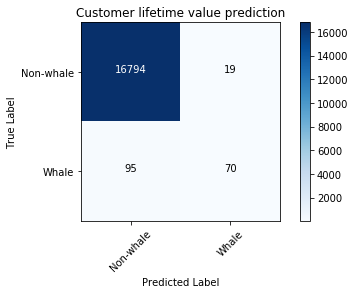

In [23]:
cm = confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [24]:
# random forest classifer, 5-fold cross-validation
scores = cross_val_score(estimator=rf_clf, X=X, y=y, scoring='f1', verbose=True, cv=5, n_jobs=-1)
"F1 %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


'F1 0.49 +/- 0.06'

In [25]:
scores

array([ 0.54117647,  0.5       ,  0.38709677,  0.54444444,  0.46666667])

In [26]:
# calculate the top 20 features based on feature importance
top_features = utils.feature_importances_old(rf_clf, features_encoded, n=20)
ft.save_features(top_features, "top_features")

1: Feature: <Feature: MODE(transactions.social_status) = unknown>, 0.104
2: Feature: <Feature: country_cd = unknown>, 0.061
3: Feature: <Feature: network = unknown>, 0.055
4: Feature: <Feature: trading_experience = SOME>, 0.052
5: Feature: <Feature: gender = MALE>, 0.038
6: Feature: <Feature: nationality = DE>, 0.037
7: Feature: <Feature: title = unknown>, 0.037
8: Feature: <Feature: network = Organic>, 0.033
9: Feature: <Feature: network = TV>, 0.033
10: Feature: <Feature: network = BUX Website>, 0.031
11: Feature: <Feature: gender = unknown>, 0.030
12: Feature: <Feature: network = Google Adwords Search>, 0.030
13: Feature: <Feature: country_cd = ES>, 0.025
14: Feature: <Feature: country_cd = NL>, 0.024
15: Feature: <Feature: network = Viral Invites>, 0.023
16: Feature: <Feature: nationality = HU>, 0.022
17: Feature: <Feature: network = AdColony>, 0.021
18: Feature: <Feature: nationality = PL>, 0.021
19: Feature: <Feature: platform_type_name = iOS>, 0.021
20: Feature: <Feature: Unname

## Retrain with top features

In [13]:
path = "data/partitioned_data/"
_, dirnames, _ = os.walk(path).__next__()
dirnames = [path+d for d in dirnames]
b = bag.from_sequence(dirnames)
entity_sets = b.map(utils.load_entity_set_10)

In [15]:
labels = entity_sets.map(utils.make_labels)
labels

dask.bag<map-mak..., npartitions=4>

In [ ]:
entity_sets_data = entity_sets.compute()[0]

In [16]:
# load in the features from before
top_features = ft.load_features("top_features", entity_sets_data)
feature_matrices = labels.map(utils.calculate_feature_matrix_top_features, features=top_features)

In [17]:
fms_out  = feature_matrices.compute()
X = pd.concat(fms_out)

[########################################] | 100% Completed |  5min 48.4s


In [18]:
# drop after rerunning DFS again
X.drop(['user_id', 'curcv', 'time'], axis=1, inplace=True)
X = X.fillna(0)
y = X.pop('label').astype('int')
y.value_counts()

0    56035
1      558
Name: label, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
f1_score(y_test, y_pred, average=None)[1]

0.38202247191011235

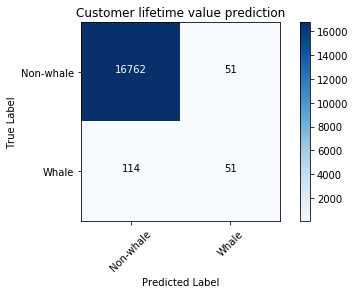

In [20]:
cm = confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [21]:
# random forest classifer, 5-fold cross-validation
scores = cross_val_score(estimator=rf_clf, X=X, y=y, scoring='f1', verbose=True, cv=5, n_jobs=-1)
"F1 %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.0s finished


'F1 0.38 +/- 0.03'

In [22]:
scores

array([ 0.42424242,  0.37078652,  0.3956044 ,  0.34831461,  0.37914692])

In [25]:
utils.feature_importances(X, rf_clf, feats=20)

1: Unnamed: 0 [0.293]
2: initial_deposit_amount [0.277]
3: MIN(transactions.total_session_duration) [0.157]
4: MAX(transactions.conversion_to_sb) [0.083]
5: MODE(transactions.account_status) = SERIOUS_BUX [0.073]
6: country_cd = AT [0.019]
7: network = Viral Invites [0.017]
8: platform_type_name = iOS [0.016]
9: network = TV [0.014]
10: network = unknown [0.014]
11: title = Rookie Trader [0.008]
12: network = Google Universal App Campaigns [0.008]
13: network = BUX Website [0.007]
14: trading_experience = NONE [0.006]
15: title = Experienced Trader [0.006]
16: network = Instagram Installs [0.002]
17: MIN(transactions.trades_fb_commodities_open) [0.000]
18: trading_experience = unknown [0.000]
19: nationality = SI [0.000]
20: platform_type_name = unknown [0.000]
-----



['Unnamed: 0',
 'initial_deposit_amount',
 'MIN(transactions.total_session_duration)',
 'MAX(transactions.conversion_to_sb)',
 'MODE(transactions.account_status) = SERIOUS_BUX',
 'country_cd = AT',
 'network = Viral Invites',
 'platform_type_name = iOS',
 'network = TV',
 'network = unknown',
 'title = Rookie Trader',
 'network = Google Universal App Campaigns',
 'network = BUX Website',
 'trading_experience = NONE',
 'title = Experienced Trader',
 'network = Instagram Installs',
 'MIN(transactions.trades_fb_commodities_open)',
 'trading_experience = unknown',
 'nationality = SI',
 'platform_type_name = unknown']

## SMOTE (oversampling)

In [76]:
# https://elitedatascience.com/imbalanced-classes
# https://chrisalbon.com/machine_learning/trees_and_forests/handle_imbalanced_classes_in_random_forests/

# https://beckernick.github.io/oversampling-modeling/

sm = SMOTE(random_state=100, ratio = 1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/home/jo/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [77]:
pd.Series(y_train_res).value_counts()

1    44822
0    44822
dtype: int64

In [78]:
%%time

clf_smote = RandomForestClassifier(n_estimators=25, random_state=12)
clf_smote.fit(X_train_res, y_train_res)

CPU times: user 28.8 s, sys: 110 ms, total: 28.9 s
Wall time: 29.1 s


In [79]:
y_pred_smote = clf_smote.predict(X_test)
y_pred_smote

array([0, 0, 0, ..., 0, 0, 0])

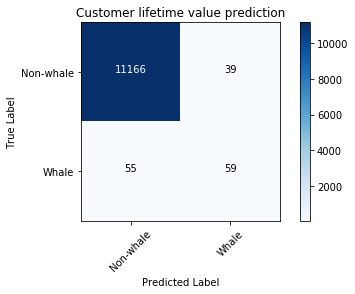

In [82]:
cm = confusion_matrix(y_test, y_pred_smote)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [86]:
# f1 score with SMOTE
f1_score(y_test, y_pred_smote, average=None)[1]

0.55660377358490576

In [87]:
top_features = utils.feature_importances(clf_smote, features_encoded, n=20)
top_features

1: Feature: initial_deposit_amount, 0.291
2: Feature: SUM(transactions.conversion_to_sb), 0.096
3: Feature: MAX(transactions.number_of_sessions), 0.069
4: Feature: STD(transactions.conversion_to_sb), 0.061
5: Feature: nationality = unknown, 0.057
6: Feature: gender = unknown, 0.057
7: Feature: gender = MALE, 0.052
8: Feature: COUNT(transactions), 0.049
9: Feature: STD(transactions.number_of_sessions), 0.044
10: Feature: MEAN(transactions.conversion_to_sb), 0.043
11: Feature: MAX(transactions.conversion_to_sb), 0.031
12: Feature: MODE(transactions.account_status) = SERIOUS_BUX, 0.028
13: Feature: NUM_UNIQUE(transactions.social_status), 0.020
14: Feature: nationality = AT, 0.010
15: Feature: MODE(transactions.account_status) = FUN_BUX, 0.007
16: Feature: MEAN(transactions.number_of_sessions), 0.006
17: Feature: NUM_UNIQUE(transactions.account_status), 0.004
18: Feature: nationality = DE, 0.004
19: Feature: network = Facebook Installs, 0.004
20: Feature: country_cd = AT, 0.003


[<Feature: initial_deposit_amount>,
 <Feature: SUM(transactions.conversion_to_sb)>,
 <Feature: MAX(transactions.number_of_sessions)>,
 <Feature: STD(transactions.conversion_to_sb)>,
 <Feature: nationality = unknown>,
 <Feature: gender = unknown>,
 <Feature: gender = MALE>,
 <Feature: COUNT(transactions)>,
 <Feature: STD(transactions.number_of_sessions)>,
 <Feature: MEAN(transactions.conversion_to_sb)>,
 <Feature: MAX(transactions.conversion_to_sb)>,
 <Feature: MODE(transactions.account_status) = SERIOUS_BUX>,
 <Feature: NUM_UNIQUE(transactions.social_status)>,
 <Feature: nationality = AT>,
 <Feature: MODE(transactions.account_status) = FUN_BUX>,
 <Feature: MEAN(transactions.number_of_sessions)>,
 <Feature: NUM_UNIQUE(transactions.account_status)>,
 <Feature: nationality = DE>,
 <Feature: network = Facebook Installs>,
 <Feature: country_cd = AT>]

## Regular (no over/undersampling)

In [88]:
# GradientBoostingRegressor(verbose=True)
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)

In [89]:
%%time

clf.fit(X_train, y_train)

CPU times: user 1min 4s, sys: 299 ms, total: 1min 4s
Wall time: 23.3 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
y_pred = clf.predict(X_test)

In [91]:
clf.score(X_test, y_test)

0.99213711458609422

In [92]:
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.9908062736812574, 0.99213711458609422, 0.99101325275267171, None)

In [93]:
# random forest classifer, 5-fold cross-validation
# clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf, X=X, y=y, scoring='f1', verbose=True, cv=5)
"F1 %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished


'F1 0.55 +/- 0.04'

In [94]:
# get F1 score for each of the folds
scores

array([ 0.55952381,  0.53551913,  0.57608696,  0.49411765,  0.60869565])

In [95]:
cm = confusion_matrix(y_test, y_pred)

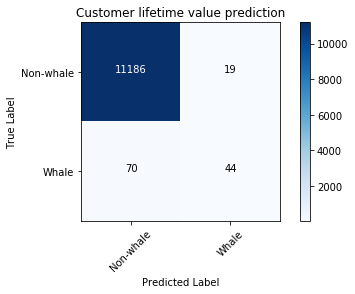

In [96]:
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [97]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average=None)

array([ 0.99603758,  0.49717514])

In [98]:
top_features = utils.feature_importances(clf, features_encoded, n=20)

1: Feature: initial_deposit_amount, 0.106
2: Feature: SUM(transactions.number_of_sessions), 0.068
3: Feature: MEAN(transactions.number_of_sessions), 0.059
4: Feature: SUM(transactions.total_session_duration), 0.051
5: Feature: STD(transactions.number_of_sessions), 0.040
6: Feature: STD(transactions.conversion_to_sb), 0.040
7: Feature: MEAN(transactions.conversion_to_sb), 0.036
8: Feature: MEAN(transactions.total_session_duration), 0.036
9: Feature: MAX(transactions.number_of_sessions), 0.034
10: Feature: MAX(transactions.total_session_duration), 0.030
11: Feature: STD(transactions.total_session_duration), 0.030
12: Feature: MAX(transactions.conversion_to_sb), 0.028
13: Feature: SUM(transactions.conversion_to_sb), 0.028
14: Feature: MODE(transactions.account_status) = SERIOUS_BUX, 0.023
15: Feature: bux_account_created_day, 0.021
16: Feature: MAX(transactions.day_of_year), 0.021
17: Feature: SUM(transactions.day_of_year), 0.020
18: Feature: MEAN(transactions.day_of_year), 0.020
19: Feat

In [99]:
ft.save_features(top_features, "top_features")

### Retrain the classifier on top 20 features

In [100]:
# load in the features from before
top_features = ft.load_features("top_features", es)

In [101]:
%%time

fm = ft.calculate_feature_matrix(top_features,
                                 entityset=es,
                                 # cutoff_time = label_times,
                                 cutoff_time_in_index=True,
                                 verbose=False)

CPU times: user 21min 57s, sys: 2.72 s, total: 21min 59s
Wall time: 22min 7s


## Classification

In [102]:
X = fm.reset_index().merge(CurCV[['user_id', 'whale']])
X = X.fillna(0)
X.drop(["user_id", "time"], axis=1, inplace=True)
y = X.pop("whale")

In [103]:
# top 20 features
len(X.columns)

20

In [104]:
y.value_counts()

0    56027
1      566
Name: whale, dtype: int64

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [106]:
# GradientBoostingRegressor(verbose=True)
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)

In [107]:
%%time

clf.fit(X_train, y_train)

CPU times: user 1min 13s, sys: 299 ms, total: 1min 14s
Wall time: 25.1 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [108]:
y_pred = clf.predict(X_test)

In [109]:
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [ 0.99431077  0.72115385]
recall: [ 0.99827453  0.43859649]
fscore: [ 0.99628871  0.54545455]
support: [16807   171]


In [110]:
%%time

clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf_cv, X=X, y=y, scoring='f1', verbose=True, cv=5)
print("F1 score %.2f +/- %.2f" % (scores.mean(), scores.std()))

F1 score 0.57 +/- 0.01
CPU times: user 7min 14s, sys: 2.08 s, total: 7min 16s
Wall time: 2min 13s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


In [ ]:
scores

In [111]:
clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf_cv, X=X, y=y, scoring='precision', verbose=True, cv=5)
print("Precision score %.2f +/- %.2f" % (scores.mean(), scores.std()))

F1 score 0.74 +/- 0.03


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


In [116]:
scores

array([ 0.796875  ,  0.72222222,  0.72151899,  0.72463768,  0.75362319])

In [117]:
# percentage of whales in each cross-validation set

lim_1 = int(len(y)/5)
lim_2 = int(len(y)/5)*2
lim_3 = int(len(y)/5)*3
lim_4 = int(len(y)/5)*4
lim_5 = int(len(y))


y[0:lim_1].value_counts()[1] / len(y[0:lim_1])*100, y[lim_1:lim_2].value_counts()[1] / len(y[lim_1:lim_2])*100, y[lim_2:lim_3].value_counts()[1] / len(y[lim_2:lim_3])*100, y[lim_3:lim_4].value_counts()[1] / len(y[lim_3:lim_4])*100, y[lim_4:lim_5].value_counts()[1] / len(y[lim_4:lim_5])*100

(0.99840961300583142,
 0.85704188019084648,
 0.99840961300583142,
 1.1309418625198799,
 1.015811324087978)

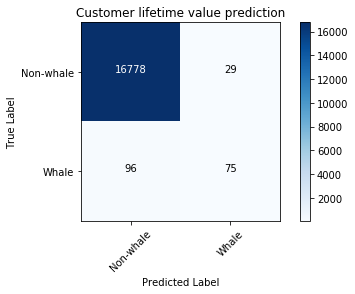

In [118]:
cm = confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

Text(0.5,1,'2-class Precision-Recall curve: AP=0.32')

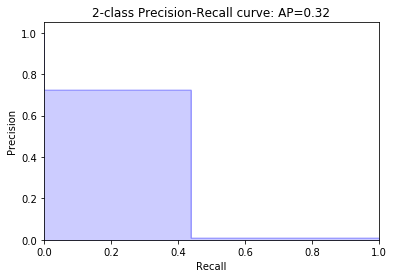

In [115]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


y_pred_proba = clf.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
pr, re, _ = precision_recall_curve(y_test,y_pred,pos_label=1)


plt.step(re, pr, color='b', alpha=0.2,
         where='post')
plt.fill_between(re, pr, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
clf_cv.decision_path(X_test)

### 30% test set (Feb 17 cohort)

![title](img/30% test set  - Feb 17 cohort.png)

## 40% test set (Feb 17 cohort)

![title](img/40% test set - Feb 17 cohort.png)

## 30% test set (Feb 17 cohort, 30k users sample)
![title](img/confusion_matrix - 30.000 users - first pipeline.png)

## Regression

In [559]:
X = fm.reset_index().merge(CurCV[['user_id', 'curcv']])
X = X.fillna(0)
X.drop(["user_id", "time"], axis=1, inplace=True)
y = X.pop("curcv")

In [560]:
len(X.columns)

20

In [561]:
# average customer value
y.mean()

6.679892666666674

In [562]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [563]:
y_train.describe()

count    10500.000000
mean         5.319653
std        113.743554
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6210.170000
Name: curcv, dtype: float64

In [564]:
y_test.describe()

count     4500.000000
mean         9.853784
std        240.957293
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      12597.100000
Name: curcv, dtype: float64

In [565]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [566]:
%%time


regr.fit(X_train, y_train)

CPU times: user 636 ms, sys: 0 ns, total: 636 ms
Wall time: 643 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [567]:
utils.feature_importances(regr, features_encoded, n=20)

1: Feature: trading_experience = NONE, 0.560
2: Feature: trading_experience = EXPERT, 0.134
3: Feature: gender = unknown, 0.087
4: Feature: nationality = IT, 0.081
5: Feature: nationality = AT, 0.055
6: Feature: trading_experience = unknown, 0.043
7: Feature: nationality = PL, 0.040
8: Feature: trading_experience = SOME, 0.000
9: Feature: gender = MALE, 0.000
10: Feature: gender = FEMALE, 0.000
11: Feature: title = Rookie Trader, 0.000
12: Feature: title = Experienced Trader, 0.000
13: Feature: title = Pro Trader, 0.000
14: Feature: title = unknown, 0.000
15: Feature: nationality = DE, 0.000
16: Feature: nationality = GB, 0.000
17: Feature: nationality = TR, 0.000
18: Feature: nationality = DK, 0.000
19: Feature: nationality = RO, 0.000
20: Feature: nationality = GR, 0.000


[<Feature: trading_experience = NONE>,
 <Feature: trading_experience = EXPERT>,
 <Feature: gender = unknown>,
 <Feature: nationality = IT>,
 <Feature: nationality = AT>,
 <Feature: trading_experience = unknown>,
 <Feature: nationality = PL>,
 <Feature: trading_experience = SOME>,
 <Feature: gender = MALE>,
 <Feature: gender = FEMALE>,
 <Feature: title = Rookie Trader>,
 <Feature: title = Experienced Trader>,
 <Feature: title = Pro Trader>,
 <Feature: title = unknown>,
 <Feature: nationality = DE>,
 <Feature: nationality = GB>,
 <Feature: nationality = TR>,
 <Feature: nationality = DK>,
 <Feature: nationality = RO>,
 <Feature: nationality = GR>]

In [568]:
y_pred = regr.predict(X_test)

In [569]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [570]:
y_test.head()

11499    0.0
6475     0.0
13167    0.0
862      0.0
5970     0.0
Name: curcv, dtype: float64

In [571]:
r2_reg = r2_score(y_test, y_pred).round(3)
r2_reg

0.107

In [572]:
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))

11.7074452488
51848.5119035
227.702683128


In [573]:
test_set_pred = sum(y_pred)
test_set_true = sum(y_test)

test_set_pred, test_set_true

(32763.885806112103, 44342.029999999984)

In [574]:
test_set_benchmark = len(y_test) * CurCV['curcv'].mean()

test_set_benchmark, test_set_true

(31986.982499999987, 44342.029999999984)

In [575]:
y_benchmark = [CurCV['curcv'].mean() for i in range(0,len(y_test))]

In [576]:
print(mean_absolute_error(y_test, y_benchmark))
print(mean_squared_error(y_test, y_benchmark))
print(np.sqrt(mean_squared_error(y_test, y_benchmark)))

16.5399014526
58055.0530432
240.946162126
